### 유동인구 예측
- 사용기법 : Random Forest

In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [5]:
df1 = pd.read_csv('../data/상권정보예측.csv')

In [6]:
df1.head()

,gid,상권밀집도,geometry,centroid,centroid_lon,centroid_lat,nearest_subway_distance,parking_1km,nearest_parking_distance,parking_500m,weighted_avg_households
0,다사385011,0.0,POLYGON ((126.80784063508459 37.10653637928979...,POINT (126.80839923101641 37.10699034270337),126.808399,37.106990,9203.670759,0,2616.915044,0,966.231874
1,다사312110,1.0,"POLYGON ((126.7247779576752 37.19526074709075,...",POINT (126.7253366940065 37.19571509699195),126.725337,37.195715,8042.302201,0,2206.415809,0,918.546292
2,다사473033,3.0,POLYGON ((126.90672137340184 37.12690343376624...,POINT (126.90728071427678 37.12735693644125),126.907281,37.127357,696.775397,393,334.022982,108,1021.022054
3,다사602117,3.0,POLYGON ((127.05149327624233 37.20325801374553...,POINT (127.05205404765378 37.20371083733202),127.052054,37.203711,911.437502,63,21.351497,39,999.497917
4,다사476205,0.0,POLYGON ((126.9088906157039 37.281954863308094...,POINT (126.90945110256466 37.28240835397451),126.909451,37.282408,3258.769915,0,5414.220356,0,892.153450


In [9]:
df2 = pd.read_csv('../data/화성시_2021년, 2022년 격자별 유동인구의 평균.csv')

In [10]:
df2.head()

,gid,pop_avg,lon,lat
0,다바145999,0.170000,126.538832,37.094558
1,다바154953,1.159996,126.549198,37.052951
2,다바154954,1.654074,126.549279,37.053929
3,다바154955,3.482000,126.549459,37.054531
4,다바155954,2.120791,126.550311,37.053862


In [11]:
df = pd.merge(df1, df2, on='gid', how='inner')

In [12]:
df.head()

,gid,상권밀집도,geometry,centroid,centroid_lon,centroid_lat,nearest_subway_distance,parking_1km,nearest_parking_distance,parking_500m,weighted_avg_households,pop_avg,lon,lat
0,다사385011,0.0,POLYGON ((126.80784063508459 37.10653637928979...,POINT (126.80839923101641 37.10699034270337),126.808399,37.106990,9203.670759,0,2616.915044,0,966.231874,20.534539,126.808500,37.107028
1,다사312110,1.0,"POLYGON ((126.7247779576752 37.19526074709075,...",POINT (126.7253366940065 37.19571509699195),126.725337,37.195715,8042.302201,0,2206.415809,0,918.546292,2.818826,126.725438,37.195753
2,다사473033,3.0,POLYGON ((126.90672137340184 37.12690343376624...,POINT (126.90728071427678 37.12735693644125),126.907281,37.127357,696.775397,393,334.022982,108,1021.022054,9.829167,126.907287,37.127469
3,다사602117,3.0,POLYGON ((127.05149327624233 37.20325801374553...,POINT (127.05205404765378 37.20371083733202),127.052054,37.203711,911.437502,63,21.351497,39,999.497917,124.511042,127.052155,37.203749
4,다사476205,0.0,POLYGON ((126.9088906157039 37.281954863308094...,POINT (126.90945110256466 37.28240835397451),126.909451,37.282408,3258.769915,0,5414.220356,0,892.153450,0.503750,126.909459,37.282371


In [13]:
df = df.drop(columns='geometry')
df = df.drop(columns='centroid')
df = df.drop(columns='lon')
df = df.drop(columns='lat')

In [14]:
df = df.drop(columns='gid')

### 버스정류장까지의 거리 column 추가

In [17]:
df_bus = pd.read_csv('../data/1-5.화성시_버스정류장.csv')
df_bus = df_bus.drop(columns=['bis_id','stn_nm'])
df_bus.head()

,lon,lat
0,126.936550,37.068417
1,126.949800,37.072233
2,126.954083,37.077617
3,126.953750,37.077883
4,126.952267,37.080050


In [18]:
df_bus.shape

(3009, 2)

In [19]:
df.head()

,상권밀집도,centroid_lon,centroid_lat,nearest_subway_distance,parking_1km,nearest_parking_distance,parking_500m,weighted_avg_households,pop_avg
0,0.0,126.808399,37.106990,9203.670759,0,2616.915044,0,966.231874,20.534539
1,1.0,126.725337,37.195715,8042.302201,0,2206.415809,0,918.546292,2.818826
2,3.0,126.907281,37.127357,696.775397,393,334.022982,108,1021.022054,9.829167
3,3.0,127.052054,37.203711,911.437502,63,21.351497,39,999.497917,124.511042
4,0.0,126.909451,37.282408,3258.769915,0,5414.220356,0,892.153450,0.503750


In [20]:
# 지구의 반지름 (6371km -> 6371000m)
EARTH_RADIUS_METERS = 6371000

# df_bus의 버스 정류장 좌표를 radians로 변환
df_bus_coords_rad = np.radians(df_bus[['lat', 'lon']].values)

# df의 격자 중심 좌표를 radians로 변환
df_coords_rad = np.radians(df[['centroid_lat', 'centroid_lon']].values)

# haversine_distances를 이용한 거리 계산
def calculate_nearest_bus_distances(df_bus_coords_rad, df_coords_rad):
    # haversine_distances로 모든 거리 계산
    distances = haversine_distances(df_coords_rad, df_bus_coords_rad) * EARTH_RADIUS_METERS
    # 각 격자 중심별 가장 가까운 거리 선택
    nearest_distances = distances.min(axis=1)
    return nearest_distances

# 결과 계산
df['nearest_bus_distance'] = calculate_nearest_bus_distances(df_bus_coords_rad, df_coords_rad)

In [21]:
df.head()

,상권밀집도,centroid_lon,centroid_lat,nearest_subway_distance,parking_1km,nearest_parking_distance,parking_500m,weighted_avg_households,pop_avg,nearest_bus_distance
0,0.0,126.808399,37.106990,9203.670759,0,2616.915044,0,966.231874,20.534539,110.160012
1,1.0,126.725337,37.195715,8042.302201,0,2206.415809,0,918.546292,2.818826,440.510731
2,3.0,126.907281,37.127357,696.775397,393,334.022982,108,1021.022054,9.829167,264.011416
3,3.0,127.052054,37.203711,911.437502,63,21.351497,39,999.497917,124.511042,145.990435
4,0.0,126.909451,37.282408,3258.769915,0,5414.220356,0,892.153450,0.503750,74.245235


### 제조업 공장까지의 거리 column 추가

In [23]:
df_fac = pd.read_csv('../data/화성시_공장등록현황.csv',encoding='cp949')

In [24]:
df_fac.columns

Index(['회사명', '행정기관명', '설립구분명', '용지면적(㎡)', '건축면적(㎡)', '종업원수', '공장규모구분명',
       '공장등록일', '용도지역명', '지목명', '업종명', '업종코드', '생산품정보', '전화번호', '정제우편번호',
       '정제도로명주소', '정제지번주소', '정제WGS84위도', '정제WGS84경도'],
      dtype='object')

In [25]:
df_fac = df_fac.drop(columns=['회사명', '행정기관명', '설립구분명', '용지면적(㎡)', '건축면적(㎡)', '종업원수', '공장규모구분명',
       '공장등록일', '용도지역명', '지목명', '업종명', '업종코드', '생산품정보', '전화번호', '정제우편번호',
       '정제도로명주소', '정제지번주소'])

In [26]:
df_fac.head()

,정제WGS84위도,정제WGS84경도
0,37.179832,127.094305
1,37.171038,127.087819
2,37.091320,126.900349
3,37.183608,126.670506
4,37.168138,126.765886


In [27]:
# 지구의 반지름 (6371km -> 6371000m)
EARTH_RADIUS_METERS = 6371000

df_fac_coords_rad = np.radians(df_fac[['정제WGS84위도', '정제WGS84경도']].values)

df_coords_rad = np.radians(df[['centroid_lat', 'centroid_lon']].values)

# haversine_distances를 이용한 거리 계산
def calculate_nearest_fac_distances(df_fac_coords_rad, df_coords_rad):
    # haversine_distances로 모든 거리 계산
    distances = haversine_distances(df_coords_rad, df_fac_coords_rad) * EARTH_RADIUS_METERS
    # 각 격자 중심별 가장 가까운 거리 선택
    nearest_distances = distances.min(axis=1)
    return nearest_distances

# 결과 계산
df['nearest_fac_distance'] = calculate_nearest_fac_distances(df_fac_coords_rad, df_coords_rad)

In [28]:
df.head()

,상권밀집도,centroid_lon,centroid_lat,nearest_subway_distance,parking_1km,nearest_parking_distance,parking_500m,weighted_avg_households,pop_avg,nearest_bus_distance,nearest_fac_distance
0,0.0,126.808399,37.106990,9203.670759,0,2616.915044,0,966.231874,20.534539,110.160012,487.308730
1,1.0,126.725337,37.195715,8042.302201,0,2206.415809,0,918.546292,2.818826,440.510731,229.835074
2,3.0,126.907281,37.127357,696.775397,393,334.022982,108,1021.022054,9.829167,264.011416,436.160627
3,3.0,127.052054,37.203711,911.437502,63,21.351497,39,999.497917,124.511042,145.990435,652.064305
4,0.0,126.909451,37.282408,3258.769915,0,5414.220356,0,892.153450,0.503750,74.245235,66.424996


In [29]:
df = df.drop(columns=['parking_1km','parking_500m'])

In [30]:
df

,상권밀집도,centroid_lon,centroid_lat,nearest_subway_distance,nearest_parking_distance,weighted_avg_households,pop_avg,nearest_bus_distance,nearest_fac_distance
0,0.0,126.808399,37.106990,9203.670759,2616.915044,966.231874,20.534539,110.160012,487.308730
1,1.0,126.725337,37.195715,8042.302201,2206.415809,918.546292,2.818826,440.510731,229.835074
2,3.0,126.907281,37.127357,696.775397,334.022982,1021.022054,9.829167,264.011416,436.160627
3,3.0,127.052054,37.203711,911.437502,21.351497,999.497917,124.511042,145.990435,652.064305
4,0.0,126.909451,37.282408,3258.769915,5414.220356,892.153450,0.503750,74.245235,66.424996
...,...,...,...,...,...,...,...,...,...
58248,2.0,127.000230,37.201701,2987.437332,412.616323,884.419620,16.928125,177.193073,202.014346
58249,0.0,126.952147,37.150108,4561.708881,2112.194812,971.591441,0.057500,852.163150,212.011927
58250,0.0,126.956458,37.177170,7106.383946,2898.022387,943.693416,0.060000,841.409243,204.730281
58251,0.0,126.887292,37.232719,2711.846675,1283.762137,826.359253,1.178182,646.964647,1401.808094


In [32]:
df.to_csv('../data/타겟/화성시_유동인구예측.csv')

### Machine Learning

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비
X = df.drop(columns=['pop_avg'])  # 특성 (입력 변수)
y = df['pop_avg']  # 타겟 (유동인구 지수)

# 데이터 분할 (학습용, 테스트용 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링 (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 기본 랜덤 포레스트 모델 설정
rf_model = RandomForestRegressor(random_state=42)

# 모델 학습
rf_model.fit(X_train_scaled, y_train)

# 예측
y_pred = rf_model.predict(X_test_scaled)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 4211.35
R^2 Score: 0.55


결과론 적으로 기본 Random Forest가 성능이 가장 좋음

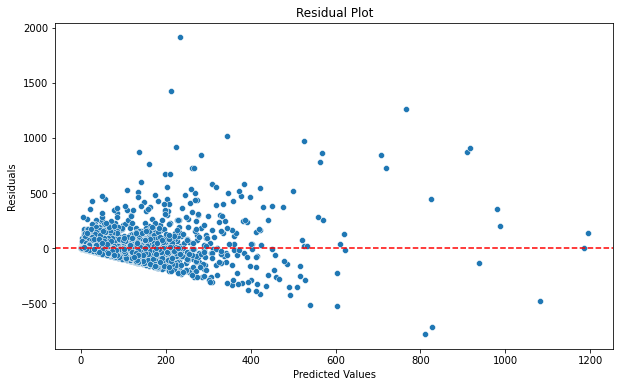

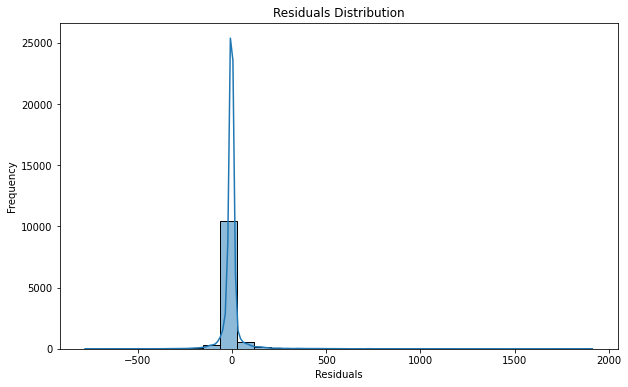

In [34]:
# 잔차 계산
residuals = y_test - y_pred

# 잔차 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# 잔차 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

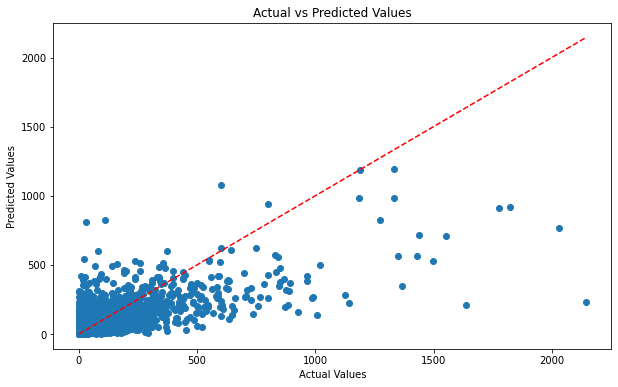

In [35]:
# 실제 값과 예측 값 비교
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [36]:
# NRMSE 계산
nrmse = np.sqrt(mse) / (y_test.max() - y_test.min())

print(f"R^2 Score: {r2:.2f}")
print(f"NRMSE (Normalized RMSE): {nrmse:.2f}")

R^2 Score: 0.55
NRMSE (Normalized RMSE): 0.03


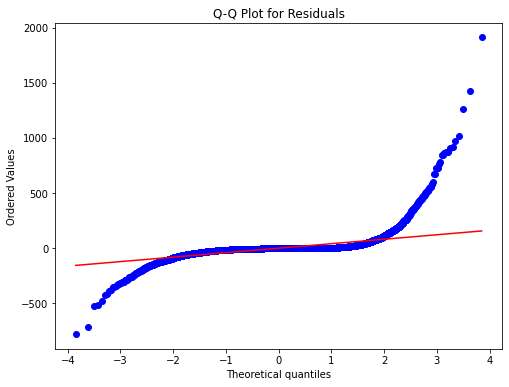

In [37]:
import scipy.stats as stats

# Q-Q 플롯
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot for Residuals')
plt.show()

In [38]:
# 훈련 데이터 예측
y_train_pred = rf_model.predict(X_train_scaled)

# 훈련 데이터 성능 평가
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 데이터 성능 평가 (이미 계산됨)
test_mse = mse
test_r2 = r2

# 결과 출력
print(f"Training MSE: {train_mse:.2f}, Training R^2: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}, Test R^2: {test_r2:.2f}")

Training MSE: 551.49, Training R^2: 0.93
Test MSE: 4211.35, Test R^2: 0.55


### Parameter 및 과적합 방지 조정 후 modeling

In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats

# 데이터 준비
X = df.drop(columns=['pop_avg'])  # 특성 (입력 변수)
y = df['pop_avg']  # 타겟 (유동인구 지수)

# Box-Cox 변환 (타겟 변수에 대해 적용)
y_positive = y + 1  # Box-Cox 변환을 위해 0 이하 값 처리 (필요한 경우)
y_boxcox, lambda_boxcox = stats.boxcox(y_positive)

# 데이터 분할 (학습용, 테스트용 데이터)
X_train, X_test, y_train_boxcox, y_test_boxcox = train_test_split(X, y_boxcox, test_size=0.2, random_state=42)

# 특성 스케일링 (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [150, 200],  # 트리 수
    'max_depth': [10, 15, 20],    # 최대 깊이
    'min_samples_split': [2,6,8,10], # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1,2,3,4],   # 리프 노드의 최소 샘플 수
    'max_features': ['sqrt'],  # 트리가 사용할 최대 특성 수
    'bootstrap': [True]    # 부트스트랩 샘플링 여부
}

# 랜덤 포레스트 모델 설정
rf_model = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# 모델 학습 (GridSearchCV로 하이퍼파라미터 튜닝)
grid_search.fit(X_train_scaled, y_train_boxcox)

# 최적 모델 추출
best_rf_model = grid_search.best_estimator_

# Box-Cox 변환된 예측값을 얻기
y_pred_boxcox = best_rf_model.predict(X_test_scaled)

# Box-Cox 예측값을 원래 스케일로 복원 (Inverse Box-Cox 변환)
y_pred_boxcox_original = np.exp(y_pred_boxcox) - 1  # Box-Cox의 역변환
y_test_boxcox_original = np.exp(y_test_boxcox) - 1  # 실제값의 역변환

# 성능 평가 - Box-Cox 변환
mse_boxcox = mean_squared_error(y_test_boxcox_original, y_pred_boxcox_original)
r2_boxcox = r2_score(y_test_boxcox_original, y_pred_boxcox_original)

# 결과 출력
print("Box-Cox 변환 결과:")
print(f"Mean Squared Error: {mse_boxcox:.2f}")
print(f"R^2 Score: {r2_boxcox:.2f}\n")

# 학습 데이터에서의 성능 평가
train_pred_boxcox = best_rf_model.predict(X_train_scaled)
train_pred_boxcox_original = np.exp(train_pred_boxcox) - 1  # 역변환
train_mse_boxcox = mean_squared_error(y_train_boxcox, train_pred_boxcox_original)
train_r2_boxcox = r2_score(y_train_boxcox, train_pred_boxcox_original)

# 학습 데이터 성능 평가 출력
print(f"Train Mean Squared Error: {train_mse_boxcox:.2f}")
print(f"Train R^2 Score: {train_r2_boxcox:.2f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   9.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  11.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   8.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   8.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   8.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total

In [40]:
# 최적 하이퍼파라미터 출력
best_params = best_rf_model.get_params()
print("최적의 하이퍼파라미터:")
for param, value in best_params.items():
    print(f"{param}: {value}")

최적의 하이퍼파라미터:
bootstrap: True
ccp_alpha: 0.0
criterion: mse
max_depth: 20
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_impurity_split: None
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 200
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
